# Distances

In [1]:
from koselleck import *

## Generating data

### Within-model Distance matrices

In [2]:
# Words to use
# words=get_valid_words()

In [3]:
# Models to use
# dfmodels = get_pathdf_models().query('period_len==5')# & 1720<=period_start')#<1900')
# dfmodels

In [5]:
# dfdist = do_gen_localdist(dfmodels.iloc[:1], force=False)
# dfdist

In [35]:
def do_gen_localdist(pathdf,words=None,force=False):
    mpath=pathdf.iloc[0].path
    ofnfn=os.path.join(os.path.dirname(mpath), 'dists.pkl')
    res=pd.DataFrame([{'path_dists':ofnfn}])
    if not force and os.path.exists(ofnfn): return res
    
    if not os.path.exists(mpath): return pd.DataFrame()
    m=load_model(mpath)

    if not words: words=get_valid_words()
    words=list(set(words) & set(m.wv.key_to_index.keys()))
    
#     vecs=m.wv.get_normed_vectors()
    vecs=m.wv.vectors
    dfmat = pd.DataFrame([
        vecs[m.wv.key_to_index[w]]
        for w in words
    ],index=words)
    
    mat_cos = fastdist.cosine_pairwise_distance(dfmat.values,return_matrix=True)
    dfsims = pd.DataFrame(mat_cos, index=words, columns=words)
    dfdist=2-dfsims
    dfdist=round(dfdist,8)
    dfdist.to_pickle(ofnfn)
    return res


def gen_within_model_dists(
        dfmodels=None,
        words=None,
        num_proc=1,
        period_len=5,
        ymin=None,
        ymax=None,
        force=False):
    dfmodels = get_pathdf_models()
    dfmodels['path_dists']=[os.path.join(os.path.dirname(p),'dists.pkl') for p in dfmodels.path]
    dfmodels = dfmodels[dfmodels.period_len==period_len]
    if ymin: dfmodels=dfmodels[dfmodels.period_start>=ymin]
    if ymax: dfmodels=dfmodels[dfmodels.period_end<=ymax]
    if not force: dfmodels=dfmodels[dfmodels.path_dists.apply(lambda p: not os.path.exists(p))]
    printm(f'#### Generating internal distances for models')
    display(dfmodels)
    if not words: words=get_valid_words()
    return pmap_groups(
        do_gen_localdist,
        dfmodels.groupby(['corpus','period','run']),
        num_proc=num_proc,
        kwargs=dict(
            words=words
        ),
        desc='Generating internal distances for models'
    )



In [7]:
# odf=gen_within_model_dists(num_proc=6)
# odf

In [8]:
# pd.read_pickle(odf.path_dists[-1]).sort_values('value')

### Across-model Distance matrices

In [34]:
def get_cross_model_dists_paths(ofn='data.all_local_dists.paths.csv',force=False,period_len=5,ymin=1720,ymax=1960):
    ofnfn=os.path.join(PATH_DATA,ofn)
    if not force and os.path.exists(ofnfn): 
        odf=read_df(ofnfn)
    else:
        dfpaths=get_model_paths_df(PATH_MODELS_BPO, 'dists.pkl').query(
            f'(period_end-period_start)==5 & period_start>={ymin} & period_end<={ymax}'
        ).sort_values('period_start')
        dfpaths['period']=[f'{x}-{y}' for x,y in zip(dfpaths.period_start, dfpaths.period_end)]
#         display(dfpaths)
        o=[]
        for i1,row1 in tqdm(dfpaths.iterrows(), total=len(dfpaths)):
            for i2,row2 in dfpaths.iterrows():
                if row1.run!=row2.run: continue
                if i1>=i2: continue
                o+=[{
                    **dict((k+'1',v) for k,v in row1.items()),
                    **dict((k+'2',v) for k,v in row2.items())
                }]
        odf=pd.DataFrame(o)
        odf.to_csv(ofnfn,index=False)
    return odf.sort_values(['period_start1','period_start2','run1','run2'])


def gen_cross_model_dists(
        dfpaths=None,
        lim=None,
        num_proc=4,
        num_runs=1,
        ofnfn=FN_ALL_LOCALDISTS_V2,
        force=False,
        **y):
    if dfpaths is None: dfpaths=get_cross_model_dists_paths()
    
    if not force and os.path.exists(ofnfn):
        odf=read_df(ofnfn)
    else:
        dfpaths_cmp_f = dfpaths_cmp.query(f'run1<="run_{str(num_runs).zfill(2)}" & run2<="run_{str(num_runs).zfill(2)}"')
        odf=pmap_groups(
            do_gen_cross_model_dists,
            dfpaths_cmp_f.iloc[:lim].groupby(['corpus1','period1','run1']),
            num_proc=num_proc,
            desc='Calculating Local Neighborhood Distance Measure over periods',
            **y
        )
        odf.to_pickle(ofnfn)
    return odf

def do_gen_cross_model_dists(pathdf,progress=False,ks=[10,25,50],progress_words=False):
    row=pathdf.iloc[0]
    dfdist1_orig=read_df(row.path1)
    
    o=[]
    iterr=tqdm(pathdf.path2,position=0) if progress else pathdf.path2
    for i2 in range(1,len(pathdf)):
        row2=pathdf.iloc[i2]
        dfdist2_orig=read_df(row2.path2)
        words = list(set(dfdist1_orig.columns) & set(dfdist2_orig.columns))
        dfdist1=dfdist1_orig[words].loc[words]
        dfdist2=dfdist2_orig[words].loc[words]

        iter2 = tqdm(words,position=0) if progress_words else words
        for w in iter2:
            neighb1_all=list(dfdist1[w].sort_values().index)
            neighb2_all=list(dfdist2[w].sort_values().index)
            
            for k in ks:
                neighb1=neighb1_all[:k+1]
                neighb2=neighb2_all[:k+1]
                metaneighb=list(set(neighb1)|set(neighb2))
                vector1=[dfdist1[w].loc[wx] for wx in metaneighb]
                vector2=[dfdist2[w].loc[wx] for wx in metaneighb]
                csim=fastdist.cosine(vector1,vector2) # returns similarity not distane!!
                dist=1-csim
                o+=[{
                    'corpus2':row2.corpus2,
                    'period2':row2.period2,
                    'run2':row2.run2,
                    'word':w,
                    'dist_local':dist,
                    'k':k
                }]
        break
    return pd.DataFrame(o)
    
def get_cross_model_dists(fnfn_cache=FN_ALL_LOCALDISTS_V2_CACHE,cache=True,force=False,**y):
    if cache and not force and os.path.exists(fnfn_cache): return read_df(fnfn_cache)
    
    odf=read_df(FN_ALL_LOCALDISTS_V2)
    odf['k']=odf['k'].apply(int)
    odf_z = pd.concat(
        dfg.assign(
            dist_local_z = (dfg.dist_local - dfg.dist_local.mean()) / dfg.dist_local.std(),
            dist_local_perc = dfg.dist_local.apply(lambda x: percentileofscore(dfg.dist_local, x))
        )
        for i,dfg in tqdm(odf.groupby('k'),desc='Normalizing scores by k-value')
    ).reset_index()
    
    # average out runs
    odf_z_mean = odf_z.groupby(['corpus1','corpus2','period1','period2','word']).mean().drop('k',1).sort_values('dist_local_perc')
    if cache: odf_z_mean.to_pickle(fnfn_cache)
    return odf_z_mean
    
    

In [13]:
# dfpaths_cmp = get_cross_model_dists_paths(force=False)
# dfpaths_cmp

In [17]:
# odf=gen_cross_model_dists(force=True,num_runs=1,num_proc=4,use_cache=False)
# odf

In [22]:
alldist_df = get_cross_model_dists()
alldist_df

dist_local  dist_local_z  \
corpus1 corpus2 period1   period2   word                                 
bpo     bpo     1740-1745 1735-1740 time        0.013222     -2.315696   
                1765-1770 1750-1755 end         0.013787     -2.303713   
                1815-1820 1875-1880 place       0.013403     -2.310591   
                1775-1780 1750-1755 time        0.014321     -2.290086   
                1765-1770 1750-1755 manner      0.013076     -2.330638   
...                                                  ...           ...   
                1895-1900 1730-1735 tact        0.431575      5.854840   
                1925-1930 1735-1740 goodwill    0.435497      5.913183   
                1930-1935 1730-1735 factor      0.449039      6.244974   
                1925-1930 1735-1740 cardigan    0.443923      6.094337   
                1750-1755 1815-1820 bouquet     0.451962      6.260124   

                                              dist_local_perc  
corpus1 corpus2 period1   period2   word                       
bpo     bpo     1740-1745 1735-1740 time             0.006573  
                1765-1770 1750-1755 end              0.007611  
                1815-1820 1875-1880 place            0.008822  
                1775-1780 1750-1755 time             0.011762  
                1765-1770 1750-1755 manner           0.012281  
...                                                       ...  
                1895-1900 1730-1735 tact            99.996022  
                1925-1930 1735-1740 goodwill        99.996367  
                1930-1935 1730-1735 factor          99.997751  
                1925-1930 1735-1740 cardigan        99.998270  
                1750-1755 1815-1820 bouquet         99.999308  

[192704 rows x 3 columns]

In [24]:
# alldist_df.query('word=="station"')

In [25]:
# alldist_df.groupby(['period1','period2']).mean().sort_values('dist_local')

## Postprocessing

## Testing data

In [27]:
dfm_word = alldist_df.groupby('word').mean().sort_values('dist_local')
dfm_word

,dist_local,dist_local_z,dist_local_perc
word,,,
time,0.032657,-1.949331,0.891470
day,0.036068,-1.862282,1.278130
part,0.036501,-1.872371,1.341898
place,0.039566,-1.813743,1.343301
end,0.040717,-1.790990,1.619804
...,...,...,...
response,0.326011,3.739062,98.851883
paralysis,0.339623,4.018120,99.811628
bouquet,0.340342,4.063374,97.792216


## Plotting data

In [33]:
def get_historical_semantic_distance_matrix(
        words=None,
        dist_key='dist_local',
        ymin=None,
        ymax=None,
        interpolate=False):
    df=get_all_localdists().reset_index()
    if type(words)==str: words=tokenize_fast(words)
    if words: df=df[df.word.isin(words)]
    if ymin: df=df.query(f'period1>="{ymin}" & period2>="{ymin}"')
    if ymax: df=df.query(f'period1<"{ymax}" & period2<"{ymax}"')
    
    # fill out other half
    pdf=df.groupby(['period1','period2']).mean().reset_index()
    pdf2=pd.DataFrame(pdf).rename(columns=dict(period1='period2',period2='period1'))
    odf=pdf.append(pdf2)
    period_types=set(odf.period1) | set(odf.period2)
    pdf3=pd.DataFrame([{'period1':x, 'period2':x, 'dist_local':0} for x in period_types])
    odf=odf.append(pdf3)
    odf=odf.pivot('period1','period2','dist_local')
    if interpolate:
        for idx in odf.index:
            odf.loc[idx] = odf.loc[idx].interpolate(limit_direction='both')
    return odf



In [31]:
# source(get_historical_semantic_distance_matrix)

In [5]:
odf=get_historical_semantic_distance_matrix(['station'])
# odf

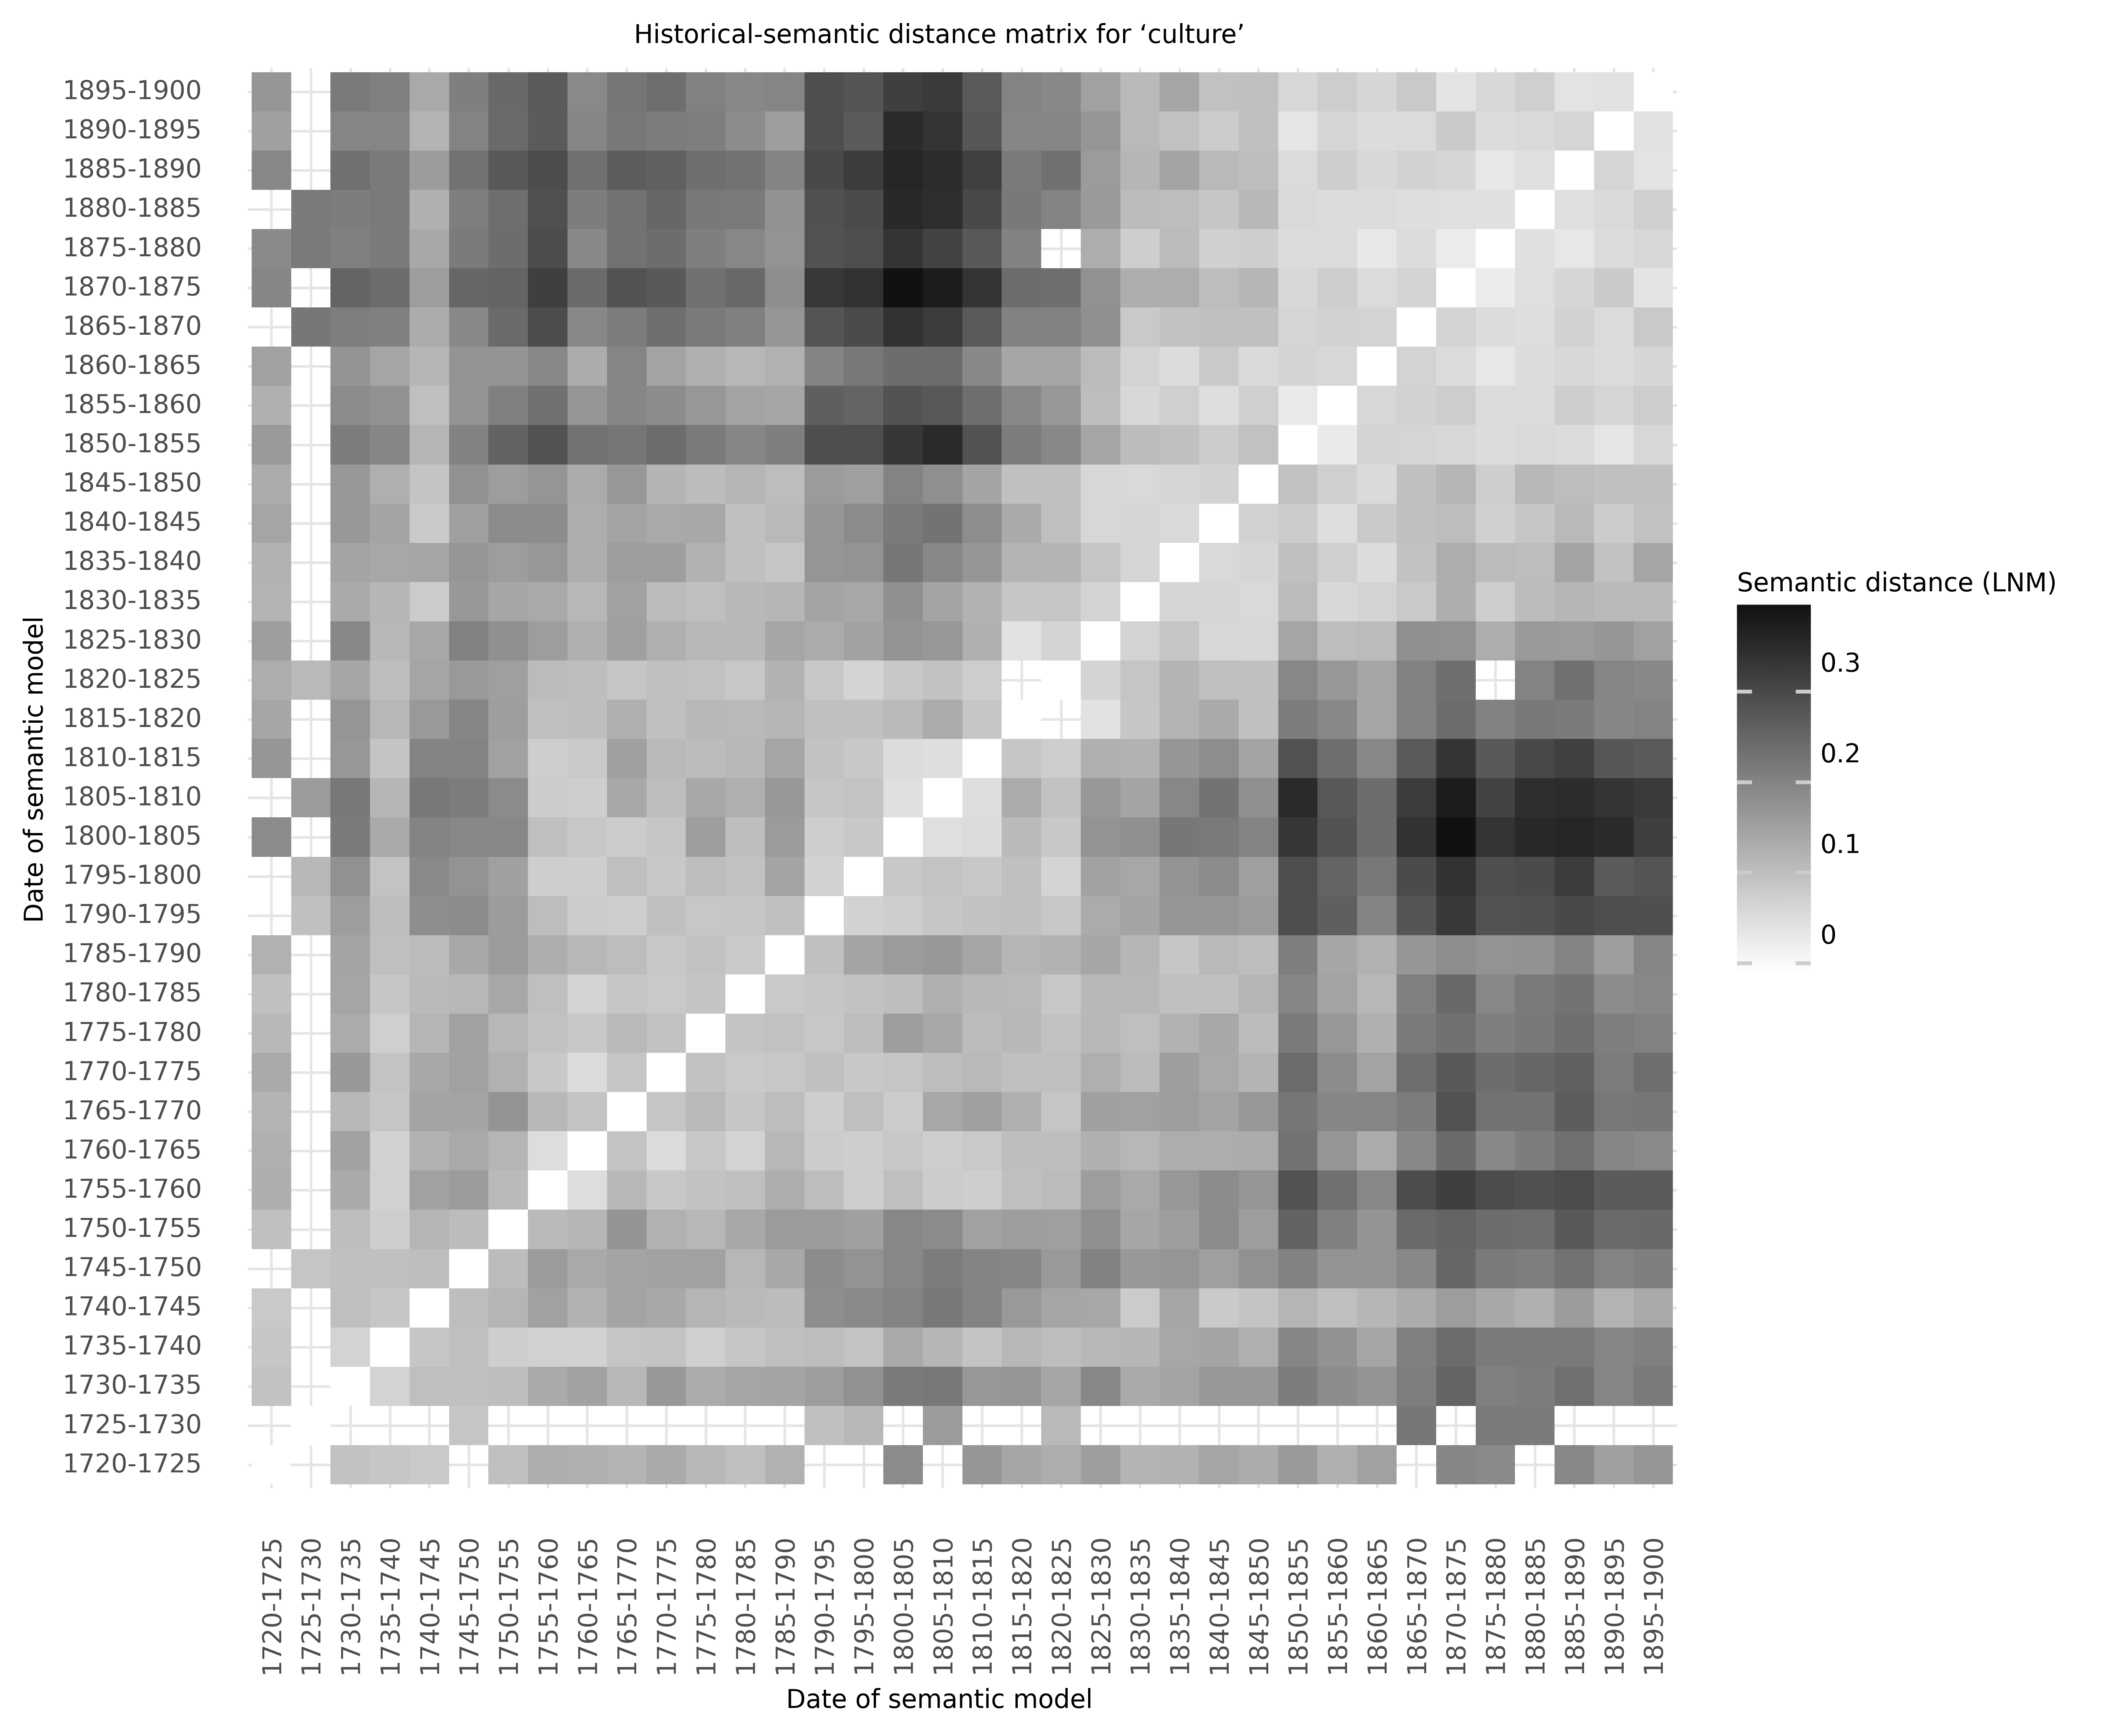

<ggplot: (382786009)>

In [14]:
plot_historical_semantic_distance_matrix('culture')

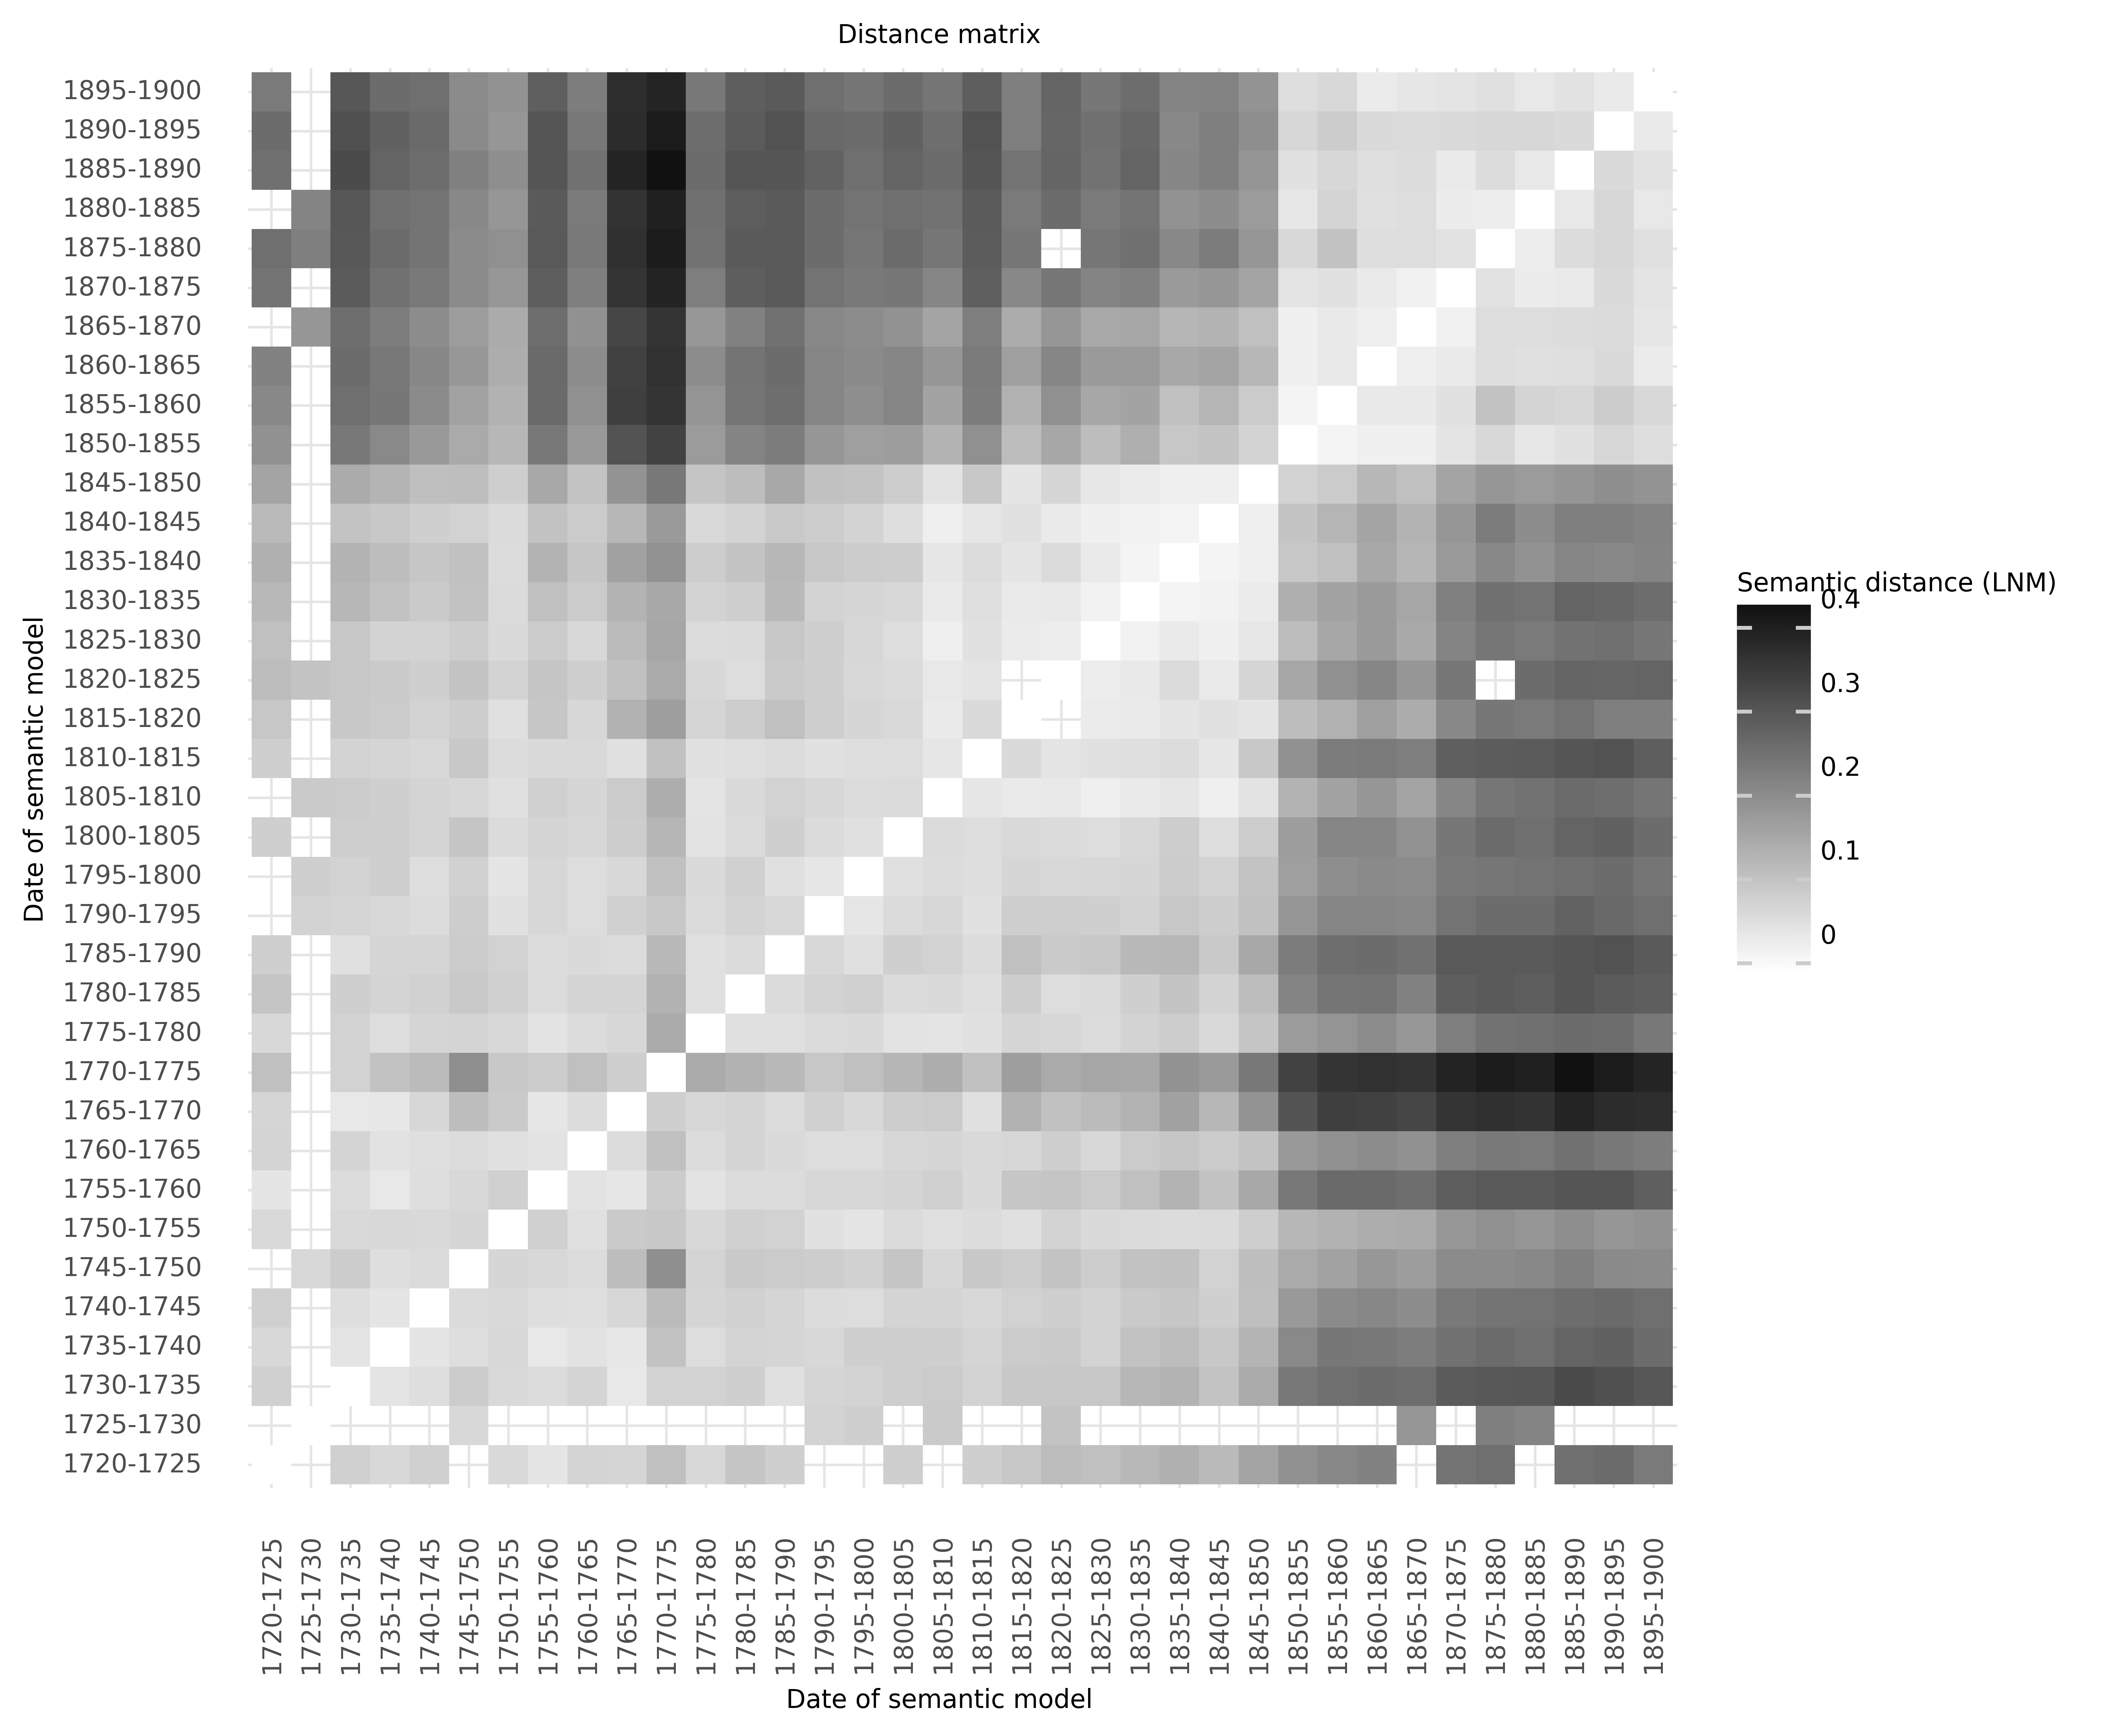

<ggplot: (274977374)>

In [8]:
plot_historical_semantic_distance_matrix('station')

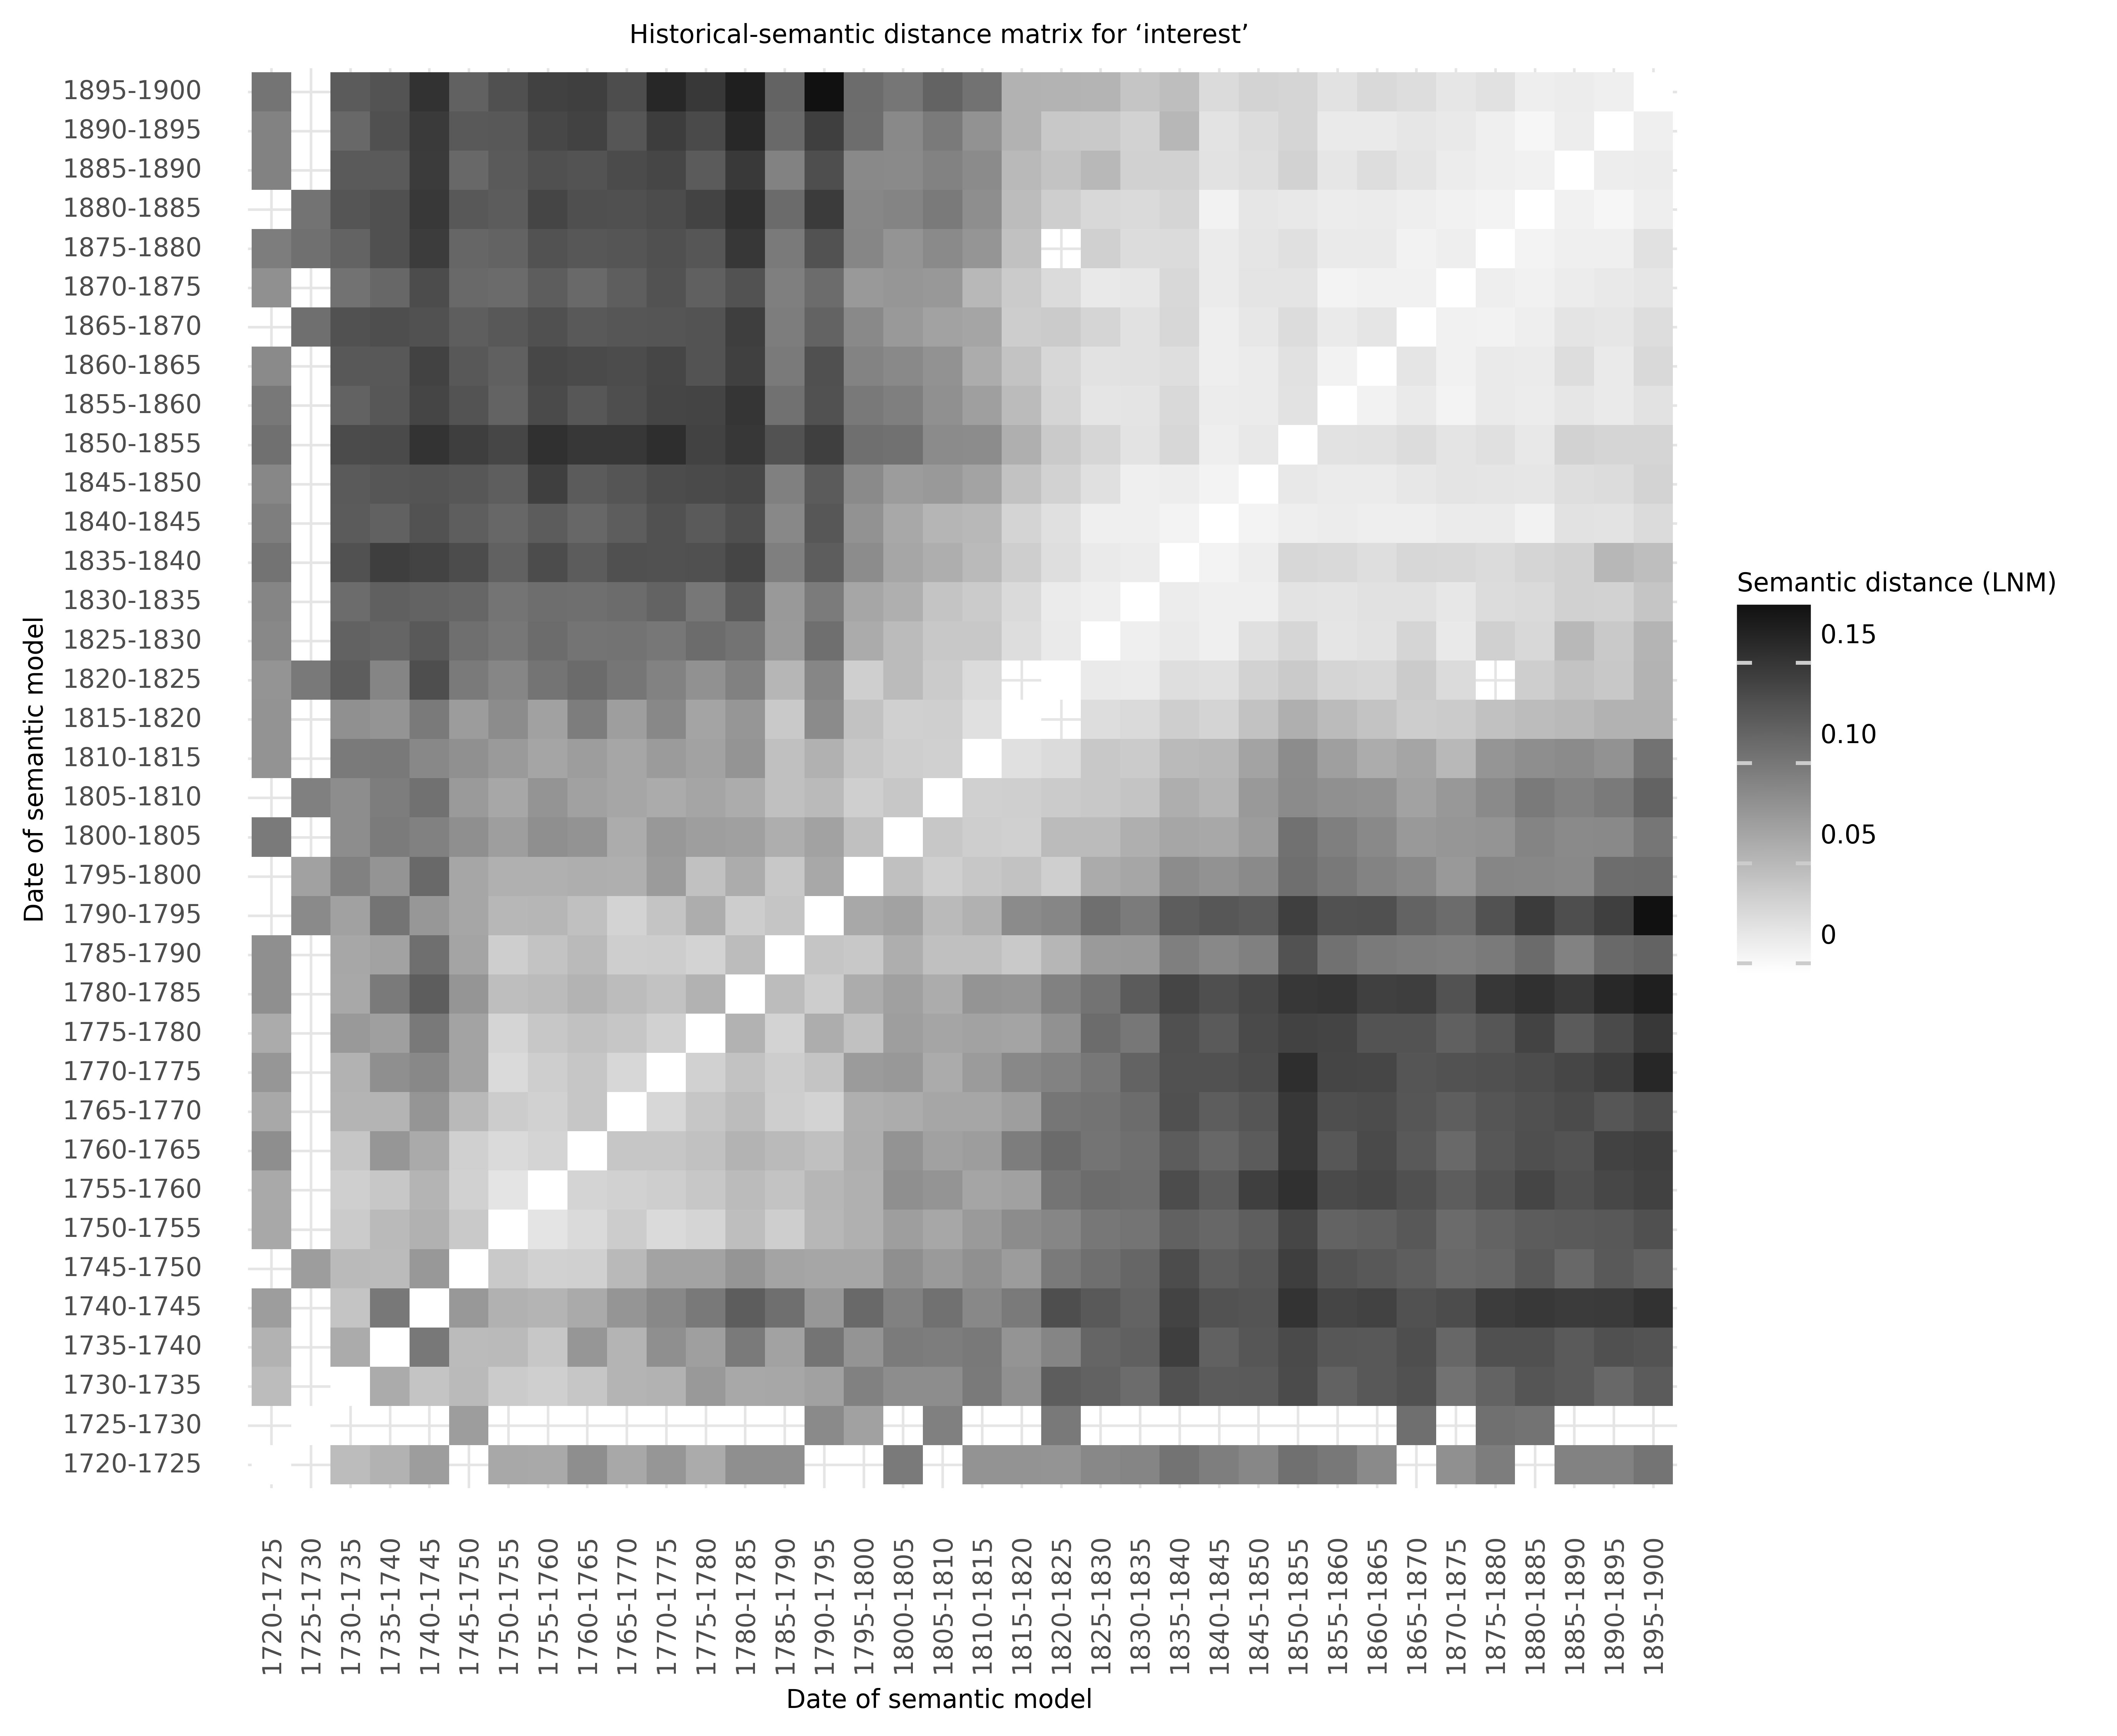

<ggplot: (396924004)>

In [20]:
plot_historical_semantic_distance_matrix('interest')

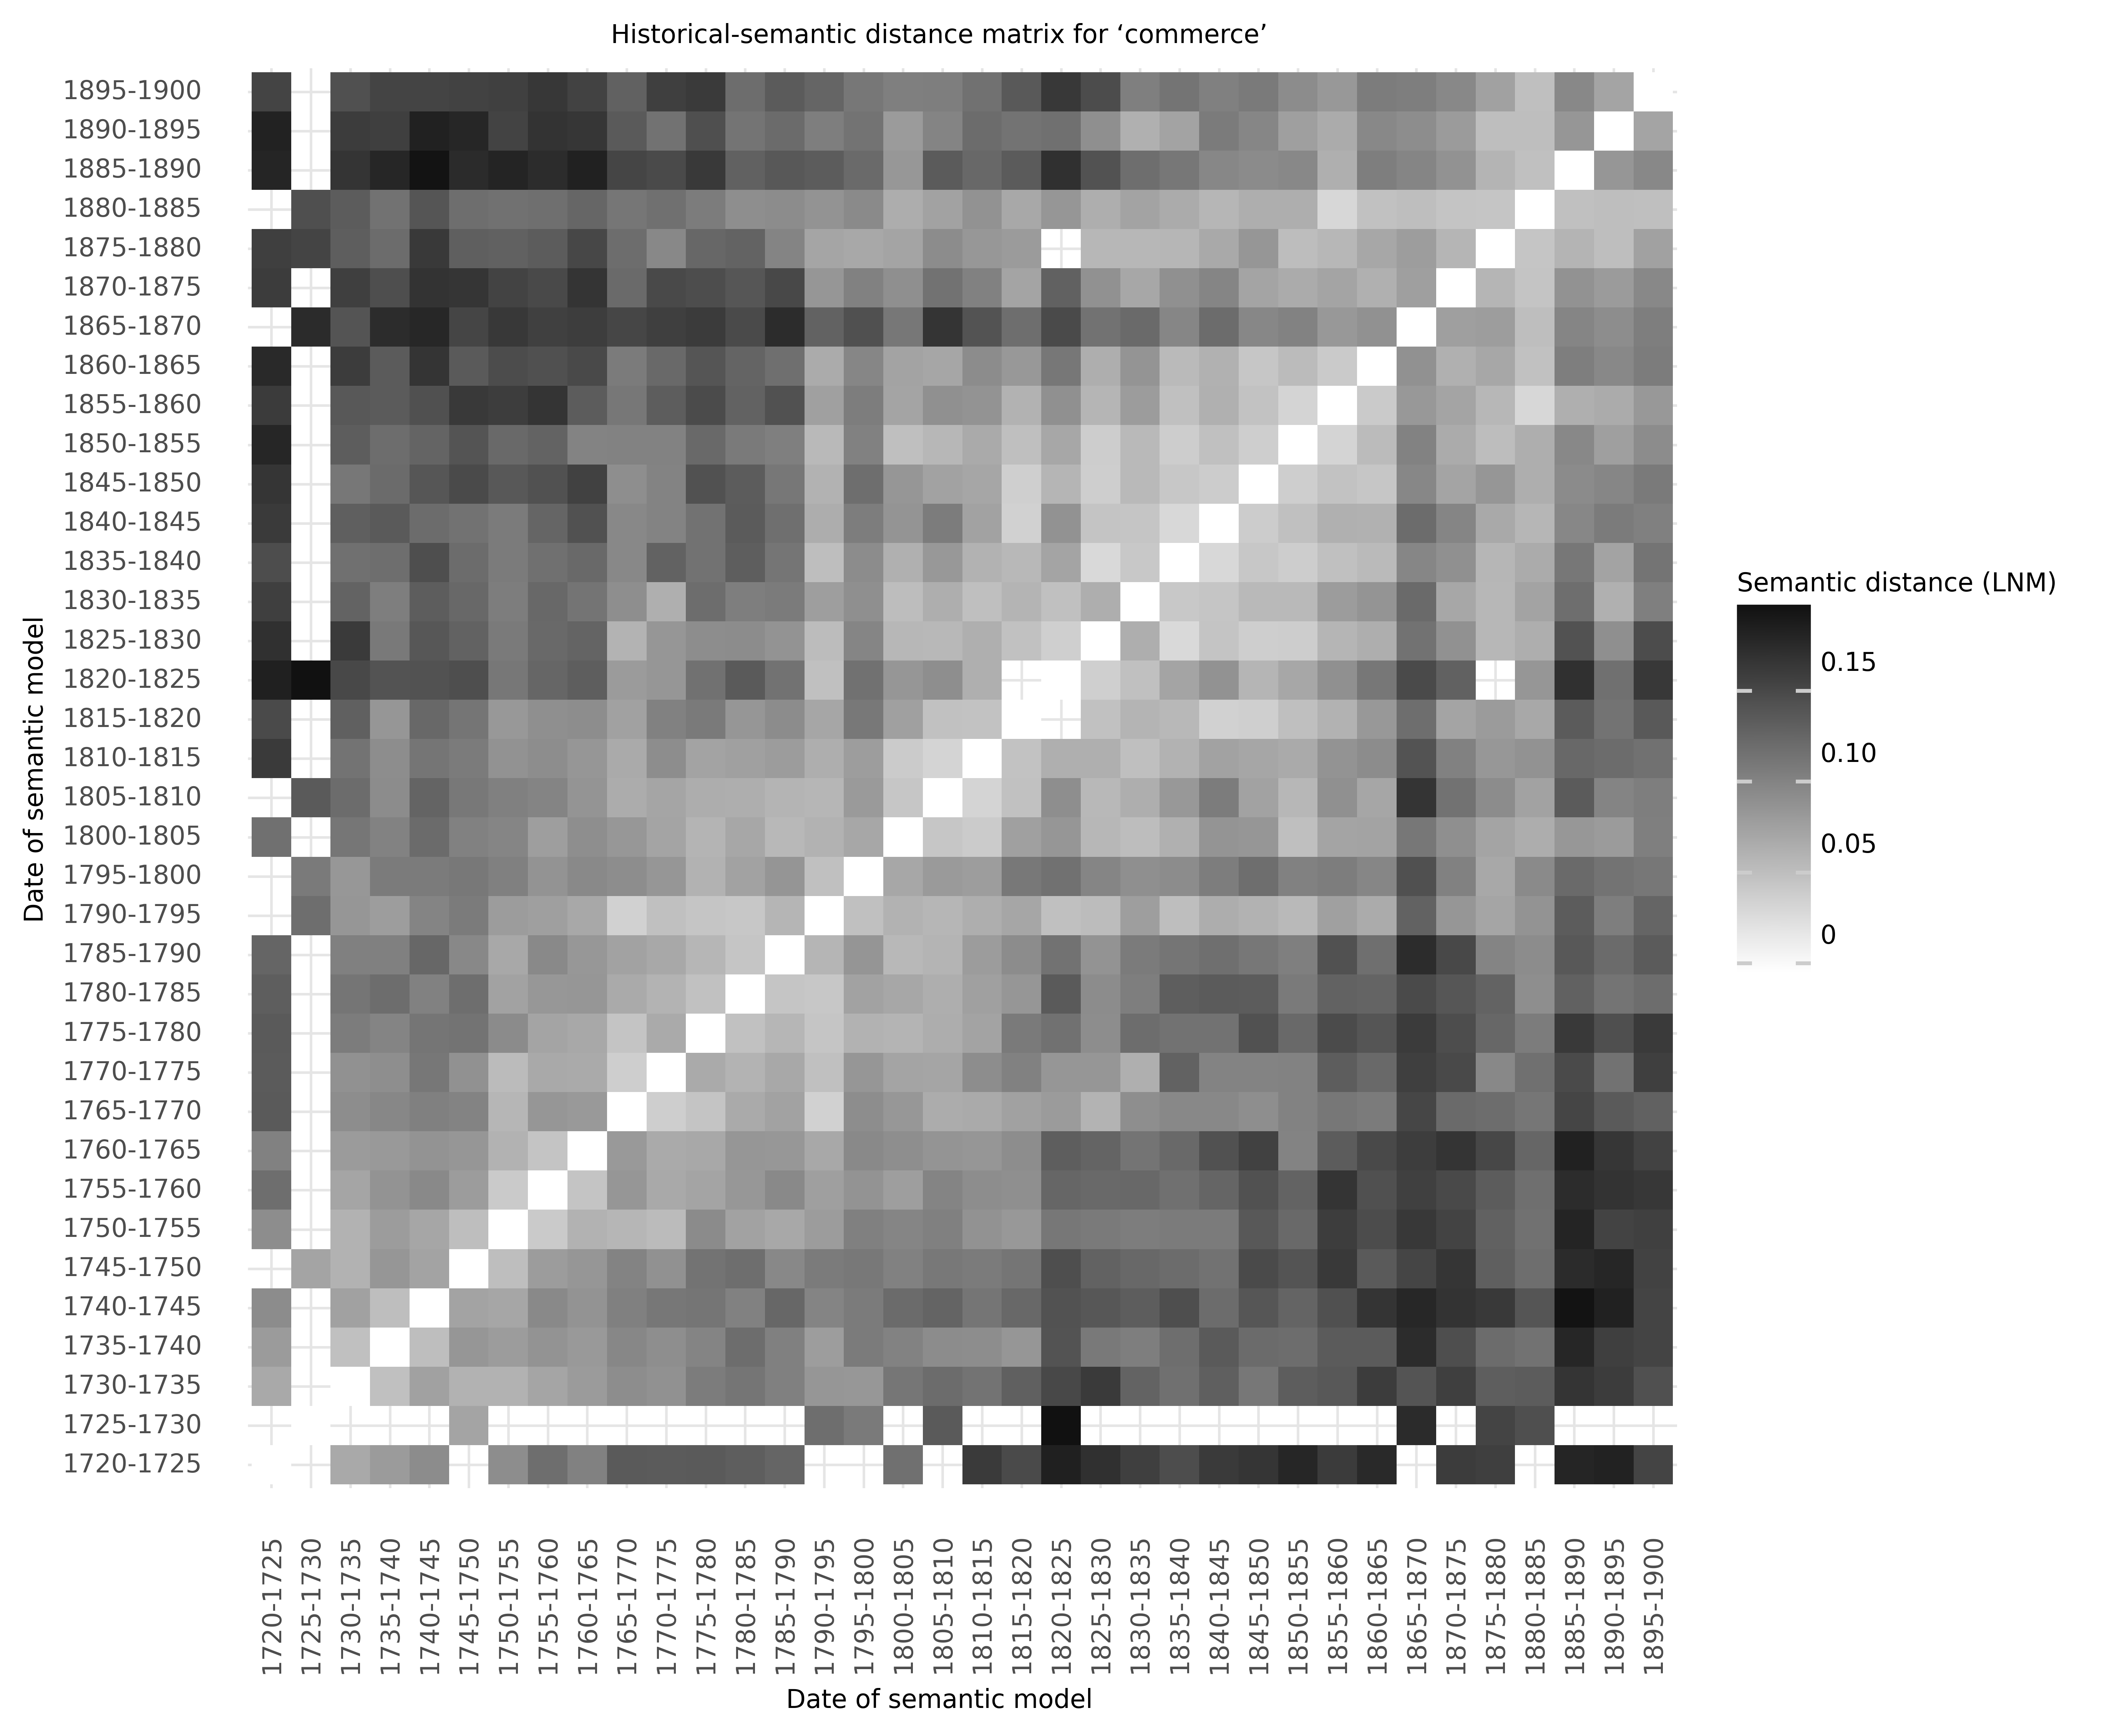

<ggplot: (391189242)>

In [21]:
plot_historical_semantic_distance_matrix('commerce')